## ExMAS
> Equilibrium matching - expieriments for the paper

---
# ILP for various Objective functions

* how can we minimize PoA with ILP

In [10]:
import os
import math
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pulp
cwd = os.getcwd()
%load_ext autoreload
%autoreload 2

In [11]:
from IPython.display import display
pd.options.display.max_columns = None

In [141]:
os.chdir(os.path.join(cwd,'../../..'))
import ExMAS.main
import ExMAS.utils
import ExMAS.games
from ExMAS.utils import inData as inData
from ExMAS.main import matching

In [104]:
params = ExMAS.utils.get_config('ExMAS/spinoffs/game/game_toy.json') # load the default 
params.t0 = pd.to_datetime(params.t0)
params.matching_obj = 'u_pax'
inData = ExMAS.utils.load_G(inData, params, stats=True)  # download the graph
inData.requests = ExMAS.utils.load_requests('ExMAS/spinoffs/game/toy.csv')

In [105]:
params.shared_discount = 0.5
params.logger_level = "CRITICAL"
inData = ExMAS.main(inData, params)
inData = ExMAS.games.prepare_PoA(inData)

In [122]:
import random
l = [1,2,3,4]
random.shuffle(l)
l

[3, 2, 1, 4]

In [15]:
OBJS = ['u_pax', 'u_veh','mean_ranking', 'mean_rel_ranking', 'mean_PoA', 'total_PoA','squared_PoA', 'min_prob','logsum_prob', 'worst']

In [140]:
import logging
inData.logger.setLevel(logging.INFO)
def user_based(inData, shuffle = False):
    served = list() # list of those already served (as a decision-makers and when decisiom was made by others)
    selected = list() # list of selected rides
    ranks = inData.sblts.ranking_matrix.values.copy() # matrix where rows are travellers and columns are groups (rides)
    # filled with nans for infeasible combinations
    # and with values for incidence (traveller being part of the group)
    # values may be: utility, probability or ranking
    travellers = list(range(ranks.shape[0]))
    if shuffle:
        random.shuffle(travellers)
    for i in travellers:  # iterate over each traveller
        if not i in served: # unless he was not served (other traveller made a decision)
            best = np.nanargmin(ranks[i,:]) # select best remaining option
            selected += [best] # add this ride to solution
            followers = ranks[:,best] # members of selected group
            followers = list(np.argwhere(~np.isnan(followers)).flatten()) 
            served += followers # to be added as already served
            inData.logger.info("{} selected {} with {}".format(i,best,followers)) # log
            for follower in followers:
                ranks[:, np.argwhere(~np.isnan(ranks[follower,:]))] = np.nan  # remove rides containing traveller i selected

        else:
            inData.logger.info("{} already served".format(i))
    return selected

    
solution = user_based(inData, shuffle = True)
inData.sblts.rides.selected = inData.sblts.rides.apply(lambda x: 1 if x.name in solution else 0, axis = 1)
inData.sblts.shedule = inData.sblts.rides[inData.sblts.rides.selected == 1].copy()



04-11-20 09:49:01-INFO-4 selected 26 with [2, 4]
04-11-20 09:49:01-INFO-5 selected 19 with [5, 7]
04-11-20 09:49:01-INFO-1 selected 12 with [0, 1]
04-11-20 09:49:01-INFO-8 selected 30 with [6, 8]
04-11-20 09:49:01-INFO-2 already served
04-11-20 09:49:01-INFO-0 already served
04-11-20 09:49:01-INFO-3 selected 3 with [3]
04-11-20 09:49:01-INFO-9 selected 9 with [9]
04-11-20 09:49:01-INFO-6 already served
04-11-20 09:49:01-INFO-7 already served


In [128]:
[11, 12, 15, 3, 19, 17, 30, 20]

[11, 12, 15, 3, 19, 17, 30, 20]

In [7]:
descs = pd.Series(OBJS).to_frame(name='obj')
descs['description'] = ['minimize traveller disutility', 
                        'min vehicle hours', 
                        'rides of minimal mean ranking (for each traveller)', 
                        'as above yet relative ranking', 
                        'minimize mean PoA of selected rides', 
                       'as above but total',
                       'as above but total and squared', 
                       'maximize minimal probability (of least satisfied traveller) of selected rides', 
                       'maximize logsum of probabilities of travellers in selected rides',
                       'worst case for comparisons - maximize disutility']
descs

,obj,description
0,u_pax,minimize traveller disutility
1,u_veh,min vehicle hours
2,mean_ranking,rides of minimal mean ranking (for each travel...
3,mean_rel_ranking,as above yet relative ranking
4,mean_PoA,minimize mean PoA of selected rides
5,total_PoA,as above but total
6,squared_PoA,as above but total and squared
7,min_prob,maximize minimal probability (of least satisfi...
8,logsum_prob,maximize logsum of probabilities of travellers...
9,worst,worst case for comparisons - maximize disutility


functions

In [8]:
def test_obj_fun(inData, obj = 'u_pax', _plot = False):
    params.matching_obj = obj
    if "prob" in obj:
        params.minmax = 'max'
    else:
        params.minmax = 'min'
    if obj == 'worst':
        params.minmax = 'max'
        params.matching_obj = 'u_pax'   
    inData = matching(inData, params, plot = False)
    if _plot:
        m_solution = inData.sblts.m.copy()
        fig, ax = plt.subplots()
        for col in m_solution.columns:
            if inData.sblts.rides.loc[col].selected==0:
                m_solution[col] = m[col]
            else:
                m_solution[col] = m[col]*5

        ax.imshow(m_solution, cmap='Greys', interpolation = 'Nearest')
        ax.set_ylabel('rides')
        _ = ax.set_xlabel('trips')
        print('grey - feasible, black - selected')
    inData = ExMAS.utils.calc_solution_PoA(inData)
    ret = dict(PassUtility = inData.sblts.schedule.u_pax.sum(),
              VehKm = inData.sblts.schedule.u_veh.sum(),
              PoA_total = inData.sblts.schedule['mean_PoA'].sum(),
              PoA_std = inData.sblts.schedule['mean_PoA'].std(),
              ranking_mean = inData.sblts.schedule['mean_rel_ranking'].mean(),
              ranking_std = inData.sblts.schedule['mean_rel_ranking'].std())
    return pd.Series(ret)

def plot_results(ret):
    fig, ax = plt.subplots(2,3,figsize=(12,9), sharey = True)
    ax = ax.flatten()
    i=0
    for KPI in ret.index:
        ret.loc[KPI].plot(kind='barh',ax = ax[i])
        ax[i].set_title(KPI)
        i+=1
    ax[2].set_xlim(0,ret.loc['PoA_total'].values[:-1].max()*1.05)
    fig.suptitle('KPIs with various objective functions')
    ax[0].set_ylabel('objectives')
    ax[3].set_ylabel('objectives')  

In [9]:
ret=dict()
for obj in OBJS:
    ret[obj]=test_obj_fun(inData, obj = obj, _plot = False)
ret = pd.DataFrame(ret)


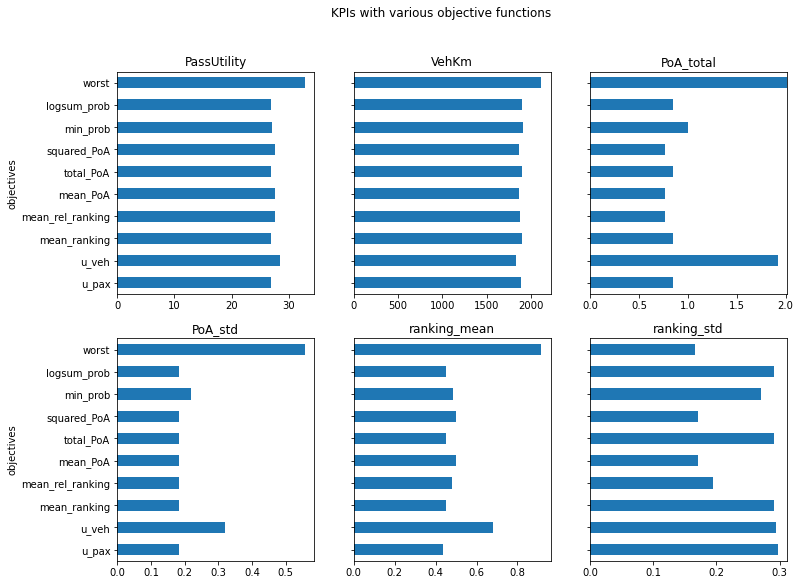

In [10]:
plot_results(ret)

In [45]:
im = inData.sblts.rides
r = inData.sblts.requests
request_indexes = dict()
request_indexes_inv = dict()
for i, index in enumerate(r.index.values):
    request_indexes[index] = i
    request_indexes_inv[i] = index

im_indexes = dict()
im_indexes_inv = dict()
for i, index in enumerate(im.index.values):
    im_indexes[index] = i
    im_indexes_inv[i] = index



im['lambda_r'] = im.apply(
    lambda x: params.shared_discount if x.kind == 1 else 1 - x.u_veh / sum([r.loc[_].ttrav for _ in x.indexes]),
    axis=1)

im['PassHourTrav_ns'] = im.apply(lambda x: sum([r.loc[_].ttrav for _ in x.indexes]), axis=1)

r = r.reset_index()

if params.profitability:
    im = im[im.lambda_r >= params.shared_discount]
    logger.info('Out of {} trips  {} are directly profitable.'.format(r.shape[0],
                                                                im.shape[0])) if logger is not None else None

nR = r.shape[0]

def add_binary_row(r):
    ret = np.zeros(nR)
    for i in r.indexes:
        ret[request_indexes[i]] = 1
    return ret


im['row'] = im.apply(add_binary_row, axis=1)  # row to be used as constrain in optimization
m = np.vstack(im['row'].values).T  # creates a numpy array for the constrains

im['index'] = im.index.copy()

im = im.reset_index(drop=True)

# optimization
maxmin = params.get('minmax','min')
if maxmin == 'min':
    prob = pulp.LpProblem("Matching problem", pulp.LpMinimize)  # problem
elif maxmin == 'max':
    prob = pulp.LpProblem("Matching problem", pulp.LpMaximize)  # problem

variables = pulp.LpVariable.dicts("r", (i for i in im.index), cat='Binary')  # decision variables

cost_col = params.matching_obj
if cost_col == 'degree':
    costs = im.indexes.apply(lambda x: -(10 ** len(x)))
elif cost_col == 'u_pax':
    costs = im[cost_col]  # set the costs
else:
    costs = im[cost_col]  # set the costs

prob += pulp.lpSum([variables[i] * costs[i] for i in variables]), 'ObjectiveFun'  # ffef

j = 0  # adding constrains
for imr in m:
    j += 1
    prob += pulp.lpSum([imr[i] * variables[i] for i in variables if imr[i] > 0]) == 1, 'c' + str(j)

    
solver = pulp.get_solver('PULP_CBC_CMD')
solver.msg = True
solver.keepFiles = True

prob.solve(solver)  # main otpimization call


# assert pulp.value(prob.objective) <= sum(costs[:nR]) + 2  # we did not go above original

locs = dict()
for variable in prob.variables():
    i = int(variable.name.split("_")[1])

    locs[im_indexes_inv[i]] = (int(variable.varValue))
    # _inData.logger.info("{} = {}".format(int(variable.name.split("_")[1]), int(variable.varValue)))

In [33]:
solver = pulp.get_solver('PULP_CBC_CMD')

In [44]:
solver.keepFiles = True

In [16]:
ret.keys()

dict_keys(['objective', 'constraints', 'name', 'sense', 'sos1', 'sos2', 'status', 'sol_status', 'noOverlap', 'solver', 'modifiedVariables', 'modifiedConstraints', 'resolveOK', '_variables', '_variable_ids', 'dummyVar', 'lastUnused', 'solutionTime'])

In [28]:
ret['constraints']

OrderedDict([('c1',
              1.0*r_0 + 1.0*r_10 + 1.0*r_11 + 1.0*r_12 + 1.0*r_22 + 1.0*r_24 + 1.0*r_31 + 1.0*r_33 + 1.0*r_34 + -1.0 = 0),
             ('c2',
              1.0*r_1 + 1.0*r_12 + 1.0*r_13 + 1.0*r_16 + 1.0*r_18 + 1.0*r_20 + 1.0*r_23 + 1.0*r_32 + -1.0 = 0),
             ('c3',
              1.0*r_14 + 1.0*r_15 + 1.0*r_2 + 1.0*r_24 + 1.0*r_25 + 1.0*r_26 + 1.0*r_27 + 1.0*r_28 + 1.0*r_34 + -1.0 = 0),
             ('c4', 1.0*r_25 + 1.0*r_3 + -1.0 = 0),
             ('c5', 1.0*r_15 + 1.0*r_26 + 1.0*r_4 + -1.0 = 0),
             ('c6',
              1.0*r_10 + 1.0*r_16 + 1.0*r_17 + 1.0*r_19 + 1.0*r_27 + 1.0*r_29 + 1.0*r_31 + 1.0*r_32 + 1.0*r_33 + 1.0*r_34 + 1.0*r_5 + -1.0 = 0),
             ('c7',
              1.0*r_13 + 1.0*r_17 + 1.0*r_18 + 1.0*r_21 + 1.0*r_30 + 1.0*r_32 + 1.0*r_6 + -1.0 = 0),
             ('c8',
              1.0*r_11 + 1.0*r_19 + 1.0*r_22 + 1.0*r_28 + 1.0*r_29 + 1.0*r_31 + 1.0*r_33 + 1.0*r_7 + -1.0 = 0),
             ('c9', 1.0*r_23 + 1.0*r_30 + 1.0*r_8

In [29]:
prob.to_json('de.json')

# big

In [11]:
params = ExMAS.utils.get_config('ExMAS/spinoffs/game/big.json') # load the default 
params.t0 = pd.to_datetime(params.t0)
params.matching_obj = 'u_pax'
inData = ExMAS.utils.load_G(inData, params, stats=True)  # download the graph

In [12]:
params.logger_level = 'INFO'
params.avg_speed
params.shared_discount = 0.3
params.avg_speed = 8
params.nP = 400
params.matching_obj = 'u_pax'
params.t0 = '17:00'
params.t0 = pd.to_datetime(params.t0)
params.VoT = 0.0035
params.WtS = 1.3
params.price = 1.5
params.horizon = -1
params.delay_value = 1.5
params.pax_delay = 10
params.max_degree = 5

In [13]:
inData = ExMAS.utils.generate_demand(inData, params)

In [14]:
inData = ExMAS.main(inData, params)

03-11-20 09:53:23-INFO-Initializing pairwise trip shareability between 400 and 400 trips.
03-11-20 09:53:23-INFO-creating combinations
03-11-20 09:53:23-INFO-159600	 nR*(nR-1)
03-11-20 09:53:31-INFO-Reduction of feasible pairs by 99.33%
03-11-20 09:53:31-INFO-Degree 2 	Completed
03-11-20 09:53:31-INFO-trips to extend at degree 2 : 2476
03-11-20 09:53:34-INFO-At degree 2 feasible extensions found out of 256 searched
03-11-20 09:53:34-INFO-Degree 3 	Completed
03-11-20 09:53:34-INFO-trips to extend at degree 3 : 256
03-11-20 09:53:35-INFO-At degree 3 feasible extensions found out of 26 searched
03-11-20 09:53:35-INFO-Degree 4 	Completed
03-11-20 09:53:35-INFO-trips to extend at degree 4 : 26
03-11-20 09:53:35-INFO-At degree 4 feasible extensions found out of 1 searched
03-11-20 09:53:35-INFO-Degree 5 	Completed
03-11-20 09:53:35-INFO-Max degree reached 5
03-11-20 09:53:35-INFO-Trips still possible to extend at degree 5 : 1
03-11-20 09:53:37-INFO-Matching 400 trips to 3159 rides in order t

In [15]:
inData = ExMAS.utils.prepare_PoA(inData)

In [19]:
for obj in OBJS:
    ret[obj]=test_obj_fun(inData, obj = obj, _plot = False)
ret = pd.DataFrame(ret)
ret

03-11-20 09:55:40-INFO-Matching 400 trips to 3159 rides in order to min u_pax
03-11-20 09:55:42-INFO-Problem solution: Optimal. 
Total costs for single trips:          3,280 
reduced by matching to:                2,940
03-11-20 09:55:45-INFO-Matching 400 trips to 3159 rides in order to min u_veh
03-11-20 09:55:47-INFO-Problem solution: Optimal. 
Total costs for single trips:        211,479 
reduced by matching to:              154,178
03-11-20 09:55:50-INFO-Matching 400 trips to 3159 rides in order to min mean_ranking
03-11-20 09:55:52-INFO-Problem solution: Optimal. 
Total costs for single trips:          5,958 
reduced by matching to:                  748
03-11-20 09:55:55-INFO-Matching 400 trips to 3159 rides in order to min mean_rel_ranking
03-11-20 09:55:57-INFO-Problem solution: Optimal. 
Total costs for single trips:            380 
reduced by matching to:                   68
03-11-20 09:56:00-INFO-Matching 400 trips to 3159 rides in order to min mean_PoA
03-11-20 09:56:02-INF

,u_pax,u_veh,mean_ranking,mean_rel_ranking,mean_PoA,total_PoA,squared_PoA,min_prob,logsum_prob,worst
PassUtility,2940.871525,3089.398875,2959.541387,2971.361350,2944.124862,2941.464337,2950.095175,2976.464800,2941.366637,3280.060500
VehKm,185483.000000,154178.000000,188331.000000,194154.000000,185576.000000,185453.000000,183266.000000,188852.000000,185534.000000,211479.000000
PoA_total,57.250000,130.275000,62.650000,64.750000,54.050000,56.750000,57.533333,99.300000,56.150000,440.000000
PoA_std,0.208352,0.388933,0.244485,0.243683,0.193491,0.203602,0.172936,0.446549,0.202682,0.638961
ranking_mean,0.403994,0.684775,0.375398,0.338285,0.380495,0.401770,0.408424,0.506642,0.399520,0.950129
ranking_std,0.298625,0.267206,0.270943,0.201975,0.268374,0.297724,0.275692,0.360963,0.295791,0.086009


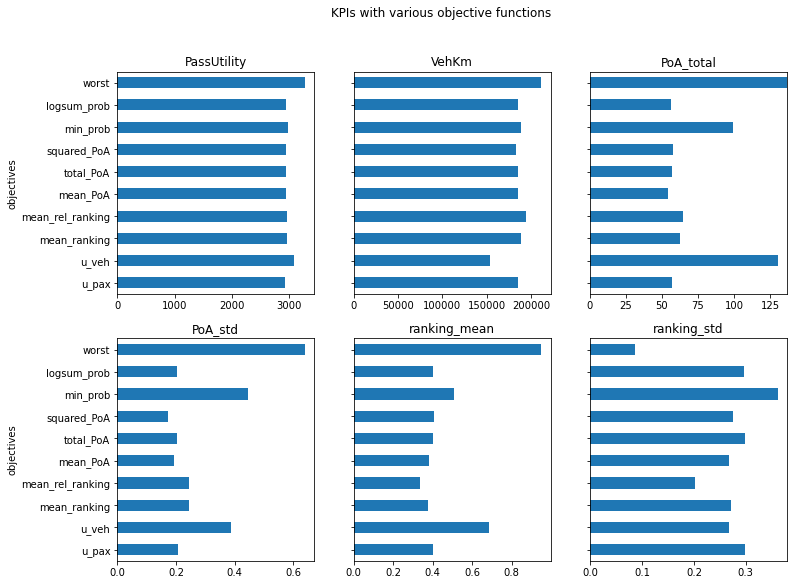

In [20]:
plot_results(ret)

---
(c) Rafał Kucharski, Delft, 2020